In [ ]:
from pyspark.sql import SparkSession  #entry point to use DataFrame Api in Spark
from pyspark.sql.functions import col,avg


spark = SparkSession.builder\
    .appName("ClimateAnalysis")\
    .config("spark.python.worker.timeout", "600")\
    .config("spark.network.timeout", "800")\
    .config("spark.executor.memory", "2g")\
    .getOrCreate()

In [2]:
import os
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("ClimateAnalysis").getOrCreate()

# Optional: Make output dir
os.makedirs("output_data", exist_ok=True)

# Load cleaned CSV directly
df = spark.read.csv("climate_data.csv", header=True, inferSchema=True)
df.show(5)


+----------+----+----+
|      Date|Tmax|Tmin|
+----------+----+----+
|1969-01-15| 3.2|-5.7|
|1969-04-15|18.4| 6.2|
|1969-07-15|30.6|18.9|
|1969-10-15|14.3| 5.1|
|1970-01-15| 2.8|-6.2|
+----------+----+----+
only showing top 5 rows


In [22]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Tmax: double (nullable = true)
 |-- Tmin: double (nullable = true)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, year, to_date, month

# Start Spark session
spark = SparkSession.builder.appName("ClimateAnalysis").getOrCreate()

# Load the CSV with its actual structure (Date, Tmax, Tmin)
df = spark.read.csv("climate_data.csv", header=True, inferSchema=True)
df.show(5)

# Convert Date column to proper date type
df = df.withColumn("date", to_date(col("Date"), "yyyy-MM-dd"))

# Calculate average temperature from Tmax and Tmin
df = df.withColumn("avg_temp", (col("Tmax") + col("Tmin")) / 2)

# Extract year from date for grouping
df = df.withColumn("year", year("date"))
df = df.withColumn("month", month("date"))  # Helpful for seasonal analysis

# Calculate annual average temperature by year
annual_avg = df.groupBy("year").agg(
    avg("Tmax").alias("avg_annual_tmax"),
    avg("Tmin").alias("avg_annual_tmin"),
    avg("avg_temp").alias("annual_avg_temp")
)

# Show annual averages
annual_avg.show()

# Compare early vs recent years:
early_years = annual_avg.filter((col("year") >= 1969) & (col("year") <= 1972))
recent_years = annual_avg.filter((col("year") >= 2019) & (col("year") <= 2022))

# Calculate averages for each period
early_avg = early_years.agg(
    avg("avg_annual_tmax").alias("tmax_early"),
    avg("avg_annual_tmin").alias("tmin_early"),
    avg("annual_avg_temp").alias("avg_temp_early")
)

recent_avg = recent_years.agg(
    avg("avg_annual_tmax").alias("tmax_recent"),
    avg("avg_annual_tmin").alias("tmin_recent"),
    avg("annual_avg_temp").alias("avg_temp_recent")
)

#  temperature changes
temp_changes = recent_avg.crossJoin(early_avg).select(
    (col("tmax_recent") - col("tmax_early")).alias("tmax_change"),
    (col("tmin_recent") - col("tmin_early")).alias("tmin_change"),
    (col("avg_temp_recent") - col("avg_temp_early")).alias("avg_temp_change")
)


temp_changes.show()


seasonal = df.groupBy("year", "month").agg(
    avg("Tmax").alias("monthly_tmax"),
    avg("Tmin").alias("monthly_tmin")
)

# winter temperatures (January)
winter_early = df.filter((col("year") >= 1969) & (col("year") <= 1972) & (col("month") == 1))
winter_recent = df.filter((col("year") >= 2019) & (col("year") <= 2022) & (col("month") == 1))

winter_change = winter_recent.agg(avg("Tmax").alias("recent_winter_tmax"), 
                                  avg("Tmin").alias("recent_winter_tmin")) \
    .crossJoin(winter_early.agg(avg("Tmax").alias("early_winter_tmax"),
                                avg("Tmin").alias("early_winter_tmin"))) \
    .select(
        (col("recent_winter_tmax") - col("early_winter_tmax")).alias("winter_tmax_change"),
        (col("recent_winter_tmin") - col("early_winter_tmin")).alias("winter_tmin_change")
    )

print("Winter temperature changes:")
winter_change.show()


#  summer temperatures (July)
summer_early = df.filter((col("year") >= 1969) & (col("year") <= 1972) & (col("month") == 7))
summer_recent = df.filter((col("year") >= 2019) & (col("year") <= 2022) & (col("month") == 7))

summer_change = summer_recent.agg(avg("Tmax").alias("recent_summer_tmax"), 
                                 avg("Tmin").alias("recent_summer_tmin")) \
    .crossJoin(summer_early.agg(avg("Tmax").alias("early_summer_tmax"),
                               avg("Tmin").alias("early_summer_tmin"))) \
    .select(
        (col("recent_summer_tmax") - col("early_summer_tmax")).alias("summer_tmax_change"),
        (col("recent_summer_tmin") - col("early_summer_tmin")).alias("summer_tmin_change")
    )

print("Summer temperature changes:")
summer_change.show()

+----------+----+----+
|      Date|Tmax|Tmin|
+----------+----+----+
|1969-01-15| 3.2|-5.7|
|1969-04-15|18.4| 6.2|
|1969-07-15|30.6|18.9|
|1969-10-15|14.3| 5.1|
|1970-01-15| 2.8|-6.2|
+----------+----+----+
only showing top 5 rows
+----+---------------+-----------------+------------------+
|year|avg_annual_tmax|  avg_annual_tmin|   annual_avg_temp|
+----+---------------+-----------------+------------------+
|2022|           18.7|            8.075|           13.3875|
|2019|         17.875|            7.375|            12.625|
|1971|          16.75|              6.4|            11.575|
|1969|         16.625|            6.125|            11.375|
|2020|          18.35|            7.975|13.162500000000001|
|1970|          16.35|            5.975|11.162499999999998|
|1972|          16.45|6.074999999999999|           11.2625|
|2021|           18.5|             7.65|13.075000000000001|
+----+---------------+-----------------+------------------+

+------------------+------------------+---------

In [6]:
from pyspark.sql.functions import lit

# After loading your CSV
df = df.withColumn("station", lit("GLOBAL"))  # Add a dummy station ID
df = df.withColumnRenamed("Tmax", "TMAX")
df = df.withColumnRenamed("Tmin", "TMIN")


In [8]:
temp_df = df.filter((col("element") == "TMAX") | (col("element") == "TMIN"))


In [7]:
df.show(5)

+----------+----+----+-------------------+----+-----+-------+
|      date|TMAX|TMIN|           avg_temp|year|month|station|
+----------+----+----+-------------------+----+-----+-------+
|1969-01-15| 3.2|-5.7|              -1.25|1969|    1| GLOBAL|
|1969-04-15|18.4| 6.2| 12.299999999999999|1969|    4| GLOBAL|
|1969-07-15|30.6|18.9|              24.75|1969|    7| GLOBAL|
|1969-10-15|14.3| 5.1|                9.7|1969|   10| GLOBAL|
|1970-01-15| 2.8|-6.2|-1.7000000000000002|1970|    1| GLOBAL|
+----------+----+----+-------------------+----+-----+-------+
only showing top 5 rows


In [ ]:
# . Filtering for the two year ranges 
early_years = df.filter((col("year") >= 1972) & (col("year") <= 1975))
recent_years = df.filter((col("year") >= 2019) & (col("year") <= 2022))

# Computing average metrics for each period 
early_metrics = early_years.agg(
    avg("TMAX").alias("tmax_early"),
    avg("TMIN").alias("tmin_early"),
    avg("avg_temp").alias("avg_temp_early"),
    (avg("TMAX") - avg("TMIN")).alias("temp_range_early")
)

recent_metrics = recent_years.agg(
    avg("TMAX").alias("tmax_recent"),
    avg("TMIN").alias("tmin_recent"),
    avg("avg_temp").alias("avg_temp_recent"),
    (avg("TMAX") - avg("TMIN")).alias("temp_range_recent")
)

# 4. Compute delta metrics (single row comparison)
comparison = recent_metrics.crossJoin(early_metrics) \
    .select(
        (col("tmax_recent") - col("tmax_early")).alias("delta_tmax"),
        (col("tmin_recent") - col("tmin_early")).alias("delta_tmin"),
        (col("avg_temp_recent") - col("avg_temp_early")).alias("delta_avg_temp"),
        (col("temp_range_recent") - col("temp_range_early")).alias("delta_range")
    )

# 5. Show the global temperature changes
print("Global temperature changes between periods:")
comparison.show()

Global temperature changes between periods:
+------------------+------------------+-----------------+------------------+
|        delta_tmax|        delta_tmin|   delta_avg_temp|       delta_range|
+------------------+------------------+-----------------+------------------+
|1.9062500000000036|1.6937499999999996|1.799999999999999|0.2125000000000039|
+------------------+------------------+-----------------+------------------+



In [ ]:
#pivoted.printSchema()

root
 |-- station: string (nullable = true)
 |-- date: date (nullable = true)
 |-- TMAX: double (nullable = true)
 |-- TMIN: double (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- year: integer (nullable = true)



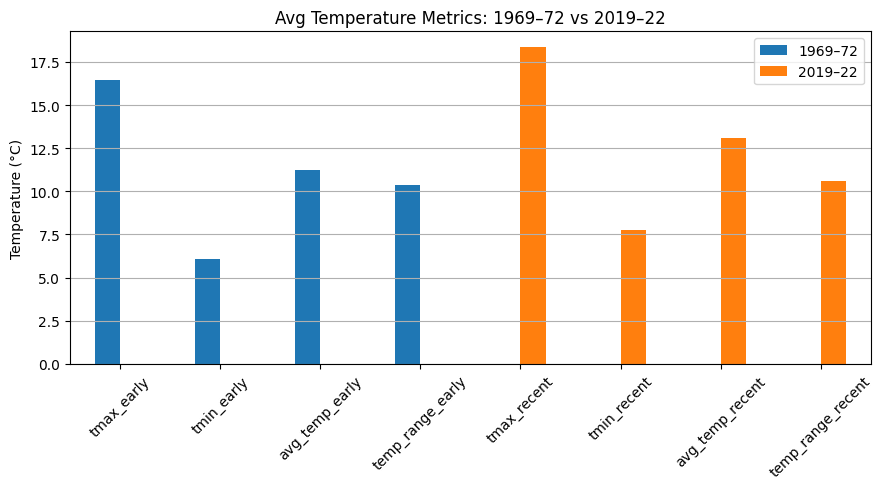

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Converting to pandas and transpose for easier plotting
early = early_metrics.toPandas().T
recent = recent_metrics.toPandas().T

# Rename columns for clarity
early.columns = ["1969–72"]
recent.columns = ["2019–22"]

# Combine into one DataFrame for side-by-side plotting
combined = pd.concat([early, recent], axis=1)

# Plot
combined.plot(kind='bar', figsize=(9, 5), color=['#1f77b4', '#ff7f0e'])  
plt.title("Avg Temperature Metrics: 1969–72 vs 2019–22")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


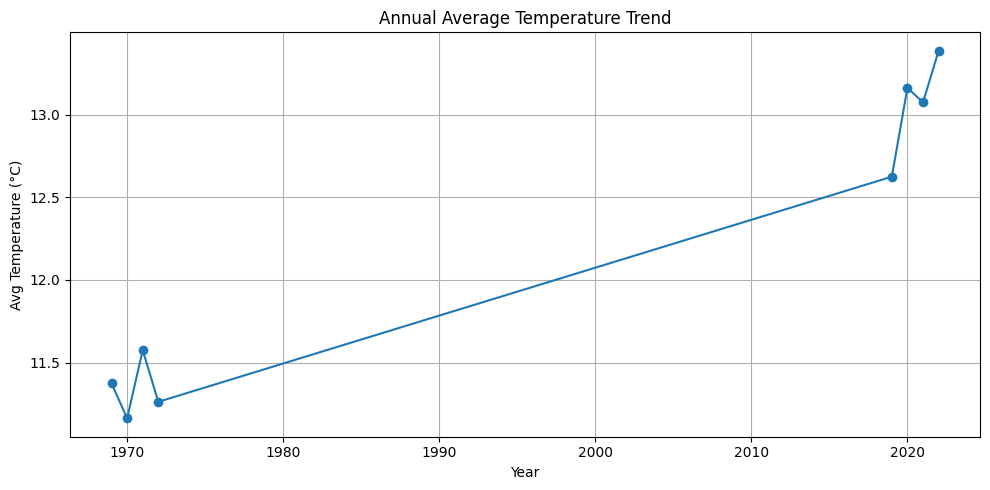

In [14]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
yearly_avg = df.groupBy("year").agg(F.avg("avg_temp").alias("mean_temp")).orderBy("year")

# Convert to Pandas for plotting
pdf = yearly_avg.toPandas()

plt.figure(figsize=(10, 5))
plt.plot(pdf["year"], pdf["mean_temp"], marker='o', linestyle='-')
plt.title("Annual Average Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Aditi Bhatt\AppData\Local\Temp\ipykernel_12648\3119042582.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([early_years["avg_temp"], recent_years["avg_temp"]],


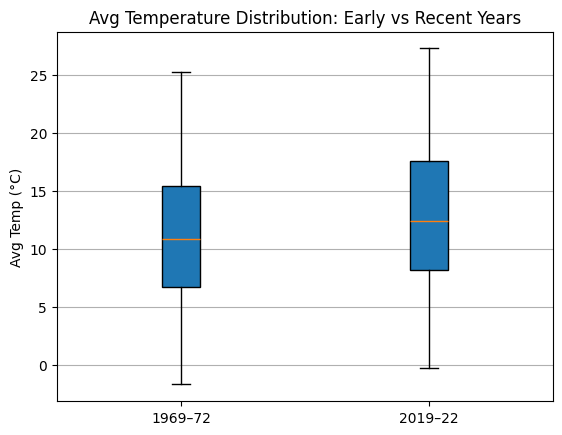

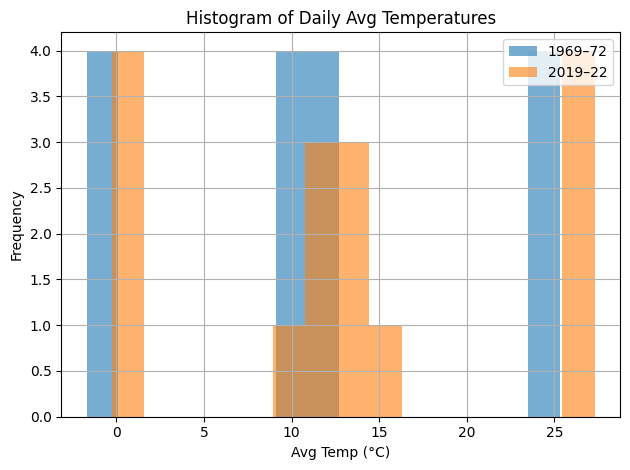

In [16]:
import matplotlib.pyplot as plt
early_years = df.filter(df.year <= 1972).select("avg_temp").toPandas()
recent_years = df.filter(df.year >= 2019).select("avg_temp").toPandas()

plt.boxplot([early_years["avg_temp"], recent_years["avg_temp"]],
            labels=["1969–72", "2019–22"], patch_artist=True)
plt.title("Avg Temperature Distribution: Early vs Recent Years")
plt.ylabel("Avg Temp (°C)")
plt.grid(True, axis='y')
plt.show()

plt.hist(early_years["avg_temp"], bins=15, alpha=0.6, label="1969–72")
plt.hist(recent_years["avg_temp"], bins=15, alpha=0.6, label="2019–22")
plt.title("Histogram of Daily Avg Temperatures")
plt.xlabel("Avg Temp (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
